# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [447]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

In [448]:
generate_student_name()

'YYPHY RYFU '

In [449]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [450]:
active_traits = 100
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.075196407410573
th 7.130072753253939 10.205269160664512
null-task passrate 0.7310585786300049
all-null passrate 2.4843785557240134e-14
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
limits 0.9978283039153395 0.9978283039153395
[[1 2 3]
 [7 8 9]]
(2, 3)


In [463]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform()  #.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [452]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt, min_active, max_active, nnw=None, optimiser=None):
        self.id = qix
        print("Qinit",qix)

        n_c = randint(min_active, max_active)
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
#         n_c =  numpy.random.choice(range(1,active_traits))
#         n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        print("Q choices are {}".format(choices))

        not_present= 0 #min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= uniform(min_diff, max_diff) #(1,11)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.thetas[c] = random.uniform(min_a, max_a)  
            self.thetas[c] = uniform(min_a, max_a) #(7,22)


In [453]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [454]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
#       if th==0:
#           return 0
        p_pass_step=1.0 if (b==0) else (1.0 / (1.0 + exp(-(th-b))))
#       print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [455]:
#qs= create_qs(n_qs, minb,maxb, n_traits, min_active_traits, max_active_traits, nnw)
def create_qs(n_qs, beta_min, beta_max, nt, min_active, max_active, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt, min_active, max_active, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
  
    return master_qs

In [456]:
def create_students(n_students, theta_min, theta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list
    

In [457]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
#     qn_qmx.trainable = True
#     psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)
#     psi_qmx_row = psi_qmx(psi_sel)

#     not_q = Lambda(lambda z: 1.0 / (1.0 + K.exp(10.0*z-5)), name="NOT_GATE")(qn_qmx_row)
#     scale = Lambda(lambda x1: 10.0*x1)
#     scale_sub = Lambda(lambda x2: 10.0*x2 - 5.0)

    
    ####
    # q0,s0 -> 1
    # q0,s1 -> 1
    # q1,s0 -> 0
    # q1,s1 -> cPr
    
#     p = scale_sub(psi_row)
#     not_q = scale(not_q)
#     qmx_selector = add([p, not_q])

    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)
#     q_masque = qn_row
#     s_masque = psi_row

#     q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
#     q0 = Lambda(lambda q: 1-q)(q_masque)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)

#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])
    
    Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1.0-ps_q[1]) ) ([Prs, q_masque])

#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

    Pr = Lambda(lambda ps: K.exp(K.sum(K.log(ps), axis=1, keepdims=True)), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [458]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                pp,passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [459]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [465]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 10
    patience = init_patience

    shuffle(attempts)

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    split = len_all//10
    
    vqices = qices[0:split] #array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
    vpsices = psices[0:split] #array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
    vpfs = pfs[0:split] #array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    qz = qices[split:]
    sz = psices[split:]
    pfz = pfs[split:]
    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
#         predz = qs_model.predict(x=[qz, sz], verbose=0)
#         print("~~~~ ~ ~ ~~~")
#         for ix,(pred,q,s,p) in enumerate(zip(predz,qz,sz,pfz)):
#             print(q,s,p,"-?",pred)
#             if ix>10:
#                 break
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))


            print("i =",i)
     
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            av_rmse = loss
            print(sum(s_table.get_weights()[0]))
            print("av RMSE=",av_rmse)
            if av_rmse <= min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
#                 qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h


In [461]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

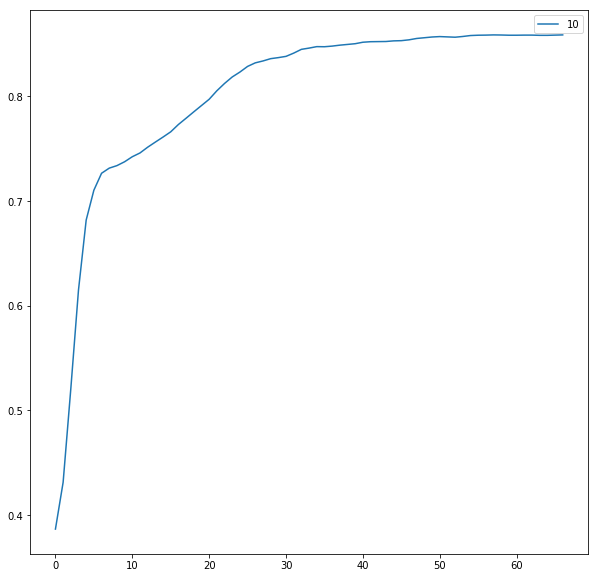

In [519]:
for h,w in zip(histoires, nn_dimensions):
    x = range(len(h))
    loss = [tup[0] for tup in h]
    acc = [tup[2] for tup in h]
#     plt.plot(x,loss, label=w)
    plt.plot(x,acc, label=w)
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()


elements in h: 67
(3.5097011898040771, 0.55769752483367918, 0.3866)
(1.7074967506408691, 0.44589430727958679, 0.43130000000000002)
(0.96074284543991084, 0.32505399556159975, 0.52070000000000005)
(0.71860265054702754, 0.24872922706604003, 0.61509999999999998)
(0.62135233812332158, 0.21033292126655578, 0.68189999999999995)
(0.57853886280059819, 0.19391524913311003, 0.71040000000000003)
(0.55585979480743408, 0.18589436895847319, 0.72660000000000002)
(0.54014727907180782, 0.180697771191597, 0.73150000000000004)
(0.53077750158309933, 0.17761660630702972, 0.7339)
(0.52354450502395633, 0.17501374650001525, 0.73760000000000003)
(0.51687012891769413, 0.17254327492713928, 0.74239999999999995)
(0.51097189016342159, 0.17025931117534637, 0.746)
(0.50484068422317507, 0.1677705204963684, 0.75149999999999995)
(0.49928604550361633, 0.16554566812515259, 0.75639999999999996)
(0.49245417480468751, 0.16278952374458314, 0.76119999999999999)
(0.48399679760932923, 0.15939890464544296, 0.76619999999999999)
(0.

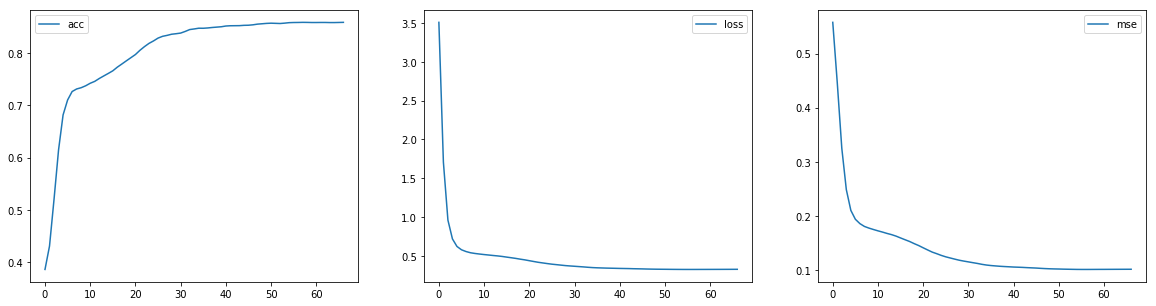

NameError: name 'b_fit_rmses' is not defined

In [520]:
clear_output()
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [530]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

for real,out in zip(real_wgtz, chosen):
    print(real," -- ",out)
# print(pred_wgts)
# print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)


s_wgtz = array([ s.thetas for s in ss ])
shat_wgtz = s_table.get_weights()[0]
shat, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(s_wgtz, shat_wgtz, max_iter=10)

for real,out in zip(s_wgtz, shat):
    print(real," -- ",out)
# print(pred_wgts)
# print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

c:\venvs\isaac64\lib\site-packages\scipy\spatial\distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          9.80091071  0.          0.
  7.44191928  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          8.90681016  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          2.40937952  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  2.59323204  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

  0.          0.          0.        ]  --  [ 0.42393357  3.33620143  4.30374622  3.57934093  6.16673374  0.          0.
  4.35004473  5.38027382  2.56421018  0.          0.          7.73513269
  5.71339941  0.13808276  0.          3.02938509  6.34002399  0.10287406
  1.05534732  0.          4.7345376   4.61543226  5.96949244  0.
  1.43019831  0.          3.90025544  3.09043789  0.          5.46389437
  2.41101217  0.          3.40215898  0.          1.61416185  4.93196821
  3.552845    6.80512619  1.85966051  2.08345318  4.58677101  1.58953631
  1.21043015  5.12394428  0.          0.79856741  1.22565448  2.1011374
  1.05802095  5.14505434  1.36824834  4.06682777  7.36857128  7.11869335
  0.          6.20411682  2.99210191  4.5165906   4.39703178  1.5813657
  3.14172649  6.93612909  3.50173998  4.72227097  3.3415246   0.          0.
  0.04937781  1.22317445  0.          0.          0.          4.49454355
  6.85301971  8.0827055   6.27713251  0.          6.20912409  0.
  1.80284953  3.10

  0.          0.          0.        ]  --  [ 4.52735949  0.09476988  0.24656636  0.          6.90468979  0.
  5.30015898  0.          3.02599072  0.          0.          1.5369724
  1.62367916  7.2542367   5.89069748  3.56909752  5.60008669  3.83814073
  6.15838671  0.          4.95391655  0.          0.          0.
  4.36466217  5.00439501  6.48051739  0.38623473  6.55794096  5.67502594
  5.14033413  3.01945925  6.12526417  4.71143866  4.64381838  0.35690701
  0.          3.49815106  6.28313398  3.99712634  4.39803362  2.66604042
  0.          5.0622406   0.          0.          0.          0.81658852
  0.          5.14195824  4.0054698   2.89317536  2.26800466  5.33860826
  0.          6.70268488  0.          4.14745378  5.30831814  1.13232481
  0.          0.          1.24970877  1.69473612  3.84500623  0.16823146
  3.59254861  0.          7.30526876  0.          2.47936988  0.
  2.31130075  2.58910561  6.77060223  4.96920776  0.          0.
  5.93847656  6.8012991   4.82540178  1.9

  0.          0.          0.          0.          0.        ]  --  [  2.99897575e+00   4.50597715e+00   1.09832883e+00   5.27102375e+00
   0.00000000e+00   5.03003693e+00   0.00000000e+00   3.36972809e+00
   4.27435732e+00   0.00000000e+00   4.27410269e+00   5.82188368e+00
   0.00000000e+00   4.53571111e-01   7.90894794e+00   0.00000000e+00
   3.62829590e+00   1.43722579e-01   1.40067983e+00   5.95034933e+00
   5.91982651e+00   7.83913517e+00   3.85710382e+00   1.32760990e+00
   7.73316063e-03   7.29786515e-01   4.32338381e+00   2.71590376e+00
   0.00000000e+00   6.76491833e+00   1.50595260e+00   1.03056669e+00
   2.28980184e+00   1.91649532e+00   3.53955531e+00   5.04643011e+00
   6.66381693e+00   1.74401212e+00   2.67653799e+00   1.14463460e+00
   0.00000000e+00   5.09181833e+00   7.48202801e+00   2.76066947e+00
   2.43991041e+00   7.14234924e+00   3.08173823e+00   6.58953428e+00
   3.28468895e+00   5.40522814e+00   2.01792932e+00   2.33730388e+00
   1.92322814e+00   5.76121044e+00  

[  6.33173704   6.80582367  12.37906402   7.56134623   7.9700814
  13.85857214   7.65066325  13.36696657  13.05666257  13.23190587
   6.4068428    6.4555689   11.84181443  13.16537688  12.01987518
   8.22460138   8.96156756   6.57191311   8.64183408   9.03419273
  13.37565092  10.5237462   11.24573994  11.81459739   7.30994765
   6.01832146   7.83992821   8.84533792  10.24322099  10.87612539
   7.00766183   7.86391303   9.9430308   13.53547587  12.91710874
   6.91541991  13.2628802   11.76194373   8.01564289   6.99374715
   9.26213511  12.41001096   9.40679541  13.51394196   9.76437752
   8.3948292    8.93657063  11.86882221  10.07873673  12.25671974
   7.30939152  12.56056605  12.76080162   9.47836324  12.14944809
  10.26378927   8.70302775   9.55407763   9.70406136   8.21231216
   7.40054512   6.15047021   7.8400954    6.49377965  13.51931603
   6.79852523  12.73597832   7.41760875  12.83582891  13.52579741
  10.21203936  11.8535191   11.69686196   7.02031614  12.65796501
   6.952660

  12.15190913   7.20584177   6.93575782   8.06992094  10.56866096]  --  [ 11.7809391   11.07973385   9.76227188   9.758811    11.63546753
  10.54853153  14.          10.78700066  13.29770565  11.9393549
  12.88055325   9.77719784  11.09378147  11.75738049  12.33795071
   7.7399025   13.65537357  14.          14.           9.71691227
  10.72678375  14.          11.7812109    6.74362469  14.          13.0919075
  11.70455074  14.           9.32644272  10.21496201  11.70517445  14.
  11.52338982  12.06513309  12.98536205  12.2641201    8.62671947
  10.36581135  11.15009022  11.50561047   7.77874947  10.34071445
   9.84370041  14.          13.55381584  13.62171745  13.66209126
  12.24886036  11.46763611  12.64758396   9.99625206  12.41832161  14.
  11.26732349  11.73955631  12.35681343  11.8532486   11.0941515
   9.11519432  14.          12.77140903  11.0190258   12.54502487
   7.82432985  10.98003101  12.84501839  10.2174387   11.86039352  14.
  13.99851704  13.23004723   9.38500118   9.8

  14.          12.88590717  11.84437847  14.        ]
[  6.62152845  11.08600871   9.12063419   7.33046879  12.41821666
   8.53181081   7.06702577   7.53664103   6.15539901   8.15350011
   8.71020659   8.27427751  11.48456941  11.73512988  11.63129468
  10.38560059   7.84192594   9.29868015  13.9566821    9.21065591
   6.23175686   6.02023279  10.4081962   13.69644768  13.38880198
   9.34349792  13.75651792  11.14308987  13.07600229   7.44007588
  13.9464025    7.42588941  13.20373026   7.84663058  11.29381245
  11.92760846  13.16780476   6.35173556   7.54137217   9.44759255
   8.49287929   7.67315099  11.8693966   11.50816293   9.7405261
  10.04808839  13.85546671   7.66012542  12.18214368  12.18883632
  11.49362155   7.04024465  10.51192964   9.57251843  10.53971712
  12.341795     8.44326079   7.14801198   9.12445739   7.40594789
  11.38263353   9.91682161   9.57014032  11.76475993   6.42904862
  12.70168806  12.59245051   7.33137785   9.86268142   7.50224416
  12.27782089  12.10291

  12.10273657  12.48643233  13.47194016  10.78039703   6.89160038]  --  [ 12.94954014  10.98553944  12.70841885  14.           9.71297836  14.          14.
  11.90039635  14.          11.1373539   10.40477085  13.79073715  14.
  12.8063612   11.00695419  11.33545113   8.74826813  11.49199295
  12.49446392  14.           9.92253399  13.52801037  12.63355255
  12.01560116   7.71660423  13.58632374  12.88432503  10.93383884  14.
  10.58321095  11.60603905   8.84672737  14.          14.          11.03540802
  10.65897083  10.57581139  10.37530136   8.77109814  12.71505833
  13.63851833  14.          14.          13.45878315   8.10747623
  12.59718513  14.          10.33556938   8.13593006  10.07390404
  13.01763439  11.65154076  13.38202381  14.           9.2100153
  10.8032856   14.           9.84074879  14.          12.21201801  14.
  13.37069893   8.97982788   9.41702461   9.13508034   9.70662498  14.
   9.80063438  14.          14.          14.          11.72587872  14.
  11.94719696  

   7.26186714  10.83472126  12.95321967   6.03940026  12.57924236]  --  [ 10.27120113  13.32237053  10.842659    13.71862793  14.          12.5977211
  13.40905094  12.32590103  10.22551727  13.67391109  13.04908276
  13.48115063  11.10975933  13.99285984  14.          11.69295597  14.
  10.60329342  10.26369476  12.33131218  11.03999138  14.           9.93243313
   9.56974792  13.74178886  10.50576782  10.58872223  11.78696537
  10.69447136  12.33731174  14.          11.77414131  14.          13.80223846
  14.          10.73868465   9.00560188  11.64592075   8.41186047  14.
  12.9013176   11.57361698  13.58670902  12.94025898  11.22794151
  12.41889477  11.6794529   14.          11.063591    11.05650234  14.
  12.97724342  11.98061848  10.63575649  14.           9.4338274
   9.47471428  10.42652798   9.49797153  13.16022491  14.          12.35731411
  14.          12.27025604  10.5550251   11.68911171  14.          12.10508823
  12.1334362   14.          14.          14.          10.8

  12.88234329  14.          11.8302927 ]
[ 10.72125012   8.32488857  11.74240734   8.05925215   8.6562476
  13.73938365   6.83801301   8.13017923   7.17719862   6.17197639
  11.9785026    6.75966121   9.98427808  11.47711025  13.13505082
   7.64422649   9.13379476   7.61590497   9.52141834  13.2604677
  13.56370753   6.82715095  13.81774057   8.58421566   6.91793471
  12.82105389  13.18008734  13.70482024   9.98058245  10.61546611
   9.24732981   9.03582193   7.28555237   8.43946196   7.29281699
  13.33885092  12.63096869  10.34279655   6.20454219  11.66999736
   7.26475603  12.20181586   9.29040449  12.92356319  13.2474142
  10.79247582   6.3554465   11.82337902  10.65930522  12.30676805
   6.70023445  10.03876617  11.79561034   6.65511591   7.08594342
   7.81585034  10.32376354   8.38992527   8.92677312   9.02627684
  13.48094878  11.8654654    6.64507362  12.84313625   8.00231971
  12.27313378  11.06504969   6.51602618   7.56128527  12.31276362
   8.29434394  11.37335523  13.9974229

  11.0945425   11.84715271  14.          12.03417778]
[ 10.56635631  13.52304657  11.94978624   9.17007512   7.57122142
  12.07998161  11.69571365  13.49634417  11.59734516   8.98580562
  12.78384289  10.59657607   8.0582559    9.12332397   6.61563125
   8.37054293  13.80230584  10.53851657   9.2802452    8.3150809
   9.67321107   6.25267049  13.68203156  12.01453686   6.36039748
  10.47277413   8.43309775  11.77841201   8.60632148  11.5994393
  13.59869299  12.34053126   9.64495309  11.35207454   9.84988674
   8.55314202  10.49779988   6.01195556  13.78951417   9.57424644
   9.95599404   7.74235708   8.32809467  10.62809788  11.46982004
  10.13910221   9.92501015   6.55211129   6.60702054  13.52683474
  10.82136425  11.63058878   7.07842807   7.02631142  10.60027525
  12.02152172  10.29703452  13.77098193  13.94599662  11.30352744
  10.11700994  11.19315068  11.94587259  12.05730254  13.73905697
  11.57348908   7.31042874  10.5919345    7.67318063   8.59989202
   6.52428248  12.041177

  11.65273393  12.46328674   8.06540225  12.07842139]  --  [ 10.37878609  14.          14.          11.34592533  13.15700817
   9.80682468  11.02565289  13.75452137  10.92295456  14.          11.26037312
  14.          11.58537865  12.60158062  12.81431389  13.45823479
  13.34766293   9.80339241  12.94033146  13.75038338  13.3635397
  10.78292084  14.          14.          12.96048737  13.3819437
  13.84931469  10.63995934  11.43683147  13.33397293   8.8786993
  11.78939819  14.          14.          12.51372242  14.           7.3365159
  12.32356453   8.68420696  14.          14.          12.45339108
  11.29375076  11.31044006  11.65987206   9.84298992   9.925313    14.
  13.3952713    9.20376015  13.60760593  10.44438076  10.93121243
  10.58371639   9.82694912  11.60038185  11.25565624  13.97103977
  10.23086357  13.21258736  12.90599251  14.          12.55904293
   7.8940196   14.          12.17003632  10.33231544   9.26454163
  12.70065212   9.86276817  13.28330135  14.          14

  11.81006343  12.1267008   12.96162245  12.67671736  12.21567889]  --  [ 11.81005192  14.           9.73989964  10.90635014  14.          13.02103806
  14.          10.57456875   9.99001503  12.32024479  13.45686245
  12.77817154   9.8394804   11.57148552  14.          13.72564507
  10.21926498  14.           9.88591766  10.68179131   8.42169666  14.          14.
  14.          14.           9.97295856  10.85932446  12.08838844
  11.44971943  14.           8.88178253  14.          12.10754395  14.
  10.50690174  14.          13.7206831   14.          13.86888695
   9.35304451  10.62388706  10.19161129  13.71910572  10.8664465
  10.82966709  12.62498951  12.28408718  10.33654976  11.25695992
  10.46410847  14.          13.65768337  14.          10.15345669
  10.89015484  10.12103367  11.05542564  10.53694153  11.03183937
   9.49661827  13.0139389   12.78867531  10.66943741  11.24452782  14.
  13.79265404  14.           9.8062315   12.88852692   8.85243511
  12.45869255  14.          14

  10.79087448   8.50286961  14.        ]
[ 13.66069549   7.72777261  11.25121963   9.4619801    7.96471799
  11.45712535  12.59182212   8.84206523  11.64705389  11.72219528
  11.89442794   6.65597789  10.92201597   7.06900716   9.58655651
  13.13249963   9.81810412   6.39035083  13.78235907  13.69780195
  12.18793144  13.95985083   9.36374403   9.54207678   7.00255072
  13.45990182  13.45227553   7.46660411   6.5201841   12.22660114
   8.37125397  10.90151202  10.72773998   6.69765429   7.63977134
   7.87506291   6.01133248   8.67734498  13.46244786   9.29920845
   6.66814316   7.4163698    6.9216308   10.7949916    6.96670472
   9.99576162   6.91672621  11.63731054   8.53635811   8.47966586
  10.35306319   6.5291221    8.09340554   8.83195118  13.04165845
   7.98513145  12.2867104   10.00747849   7.64836121  12.92758694
  10.6900485    6.18816866  12.58772832  13.57848399   8.11283527
  12.55519215  12.33602205  12.63452618  12.56458651   7.22871132
   9.97895165   7.25361234  10.2430

   7.29387384  11.29803035  13.56691892  12.78458603   6.9690568 ]  --  [ 10.45633984  14.          14.          11.76003933   9.39972782  14.
   6.86787367  11.66588306  10.68725109  12.72421741  14.          13.47891712
  12.10423279   9.06995869   7.15998888  12.78133392  14.          13.34574223
   9.96337223  12.92609787   6.60384703   9.14608383   7.79220867
   8.60604382  12.69361973  14.          13.44856834  12.34038639
  10.36721802  12.59619236  10.25617027  14.          10.47034931
  13.36805153  12.74567699  10.60679245  10.53142834  11.46042442
  12.29027557  13.229002    13.89334106  13.52555084  11.4981575
   7.03840256  13.60910416   7.60796833  10.47514915  14.          14.
  10.52806473  11.85142326  10.08083439  10.75289345  13.48488331  14.
  11.83913612  10.74730396  12.0605669   12.71678352  13.29618073
  10.1078949   10.77876759  13.99916649  12.91101837  10.82496643
  11.43002605  13.48524475  10.29479599  14.          12.11610222  14.
  10.06367397  14.       

  12.66402599  11.79002105   8.81643036  13.01506582   6.58614167]  --  [ 11.92419147  11.38126755  12.34378052  11.09894657  11.86004734  14.          14.
  14.           9.63574123  12.77956295  10.56948662  11.0255146
  12.12116528  14.          13.60267258  13.34057522  13.38518524
   9.3392725   11.38575363  11.61615372  14.           8.32971001
  12.88075352  13.4084692   12.16477299   9.58933735   9.68312263
  12.9569416   10.10951996  10.15705299   7.92866468  11.14976978  14.
  10.7626667   14.          13.50835037  12.12471485  11.12154388  14.
  11.56003857  14.          10.37210655   9.99142742  12.83935738
  13.07681179   8.98777199  11.81276417  10.5509901   14.          14.          14.
  14.          11.62152863  11.12050056  10.64887142  14.          12.68535709
  14.          12.60770607  11.75976086  13.50057983  10.75213432
  10.64815331  11.11721897  13.91445255  13.82411957  10.71086025  14.
  10.90780544  11.90055656  12.59060287  13.38638878  14.           9.395

  12.89532757  14.          14.        ]
[  8.30091613  11.48143934   8.5772201   10.79358732   6.0682884   10.336131
   7.86738237  10.31145713  13.30667386  10.06431062  12.55243154
  13.58846976   7.15316381  13.58102486   8.79963396  13.50955901
   7.94048337  12.0368899    6.72431197   6.46535911   9.89297625
  10.42656239   9.04508696   9.66067079   6.37248631  10.4201556
  12.7235671    7.08941888  10.13149054   8.7714262    8.25185681
  11.69851902  12.94671081   9.87054183  11.54251485   8.41687089
   7.10783808  11.17852089   8.20917126  12.69222156   6.53459503
   8.8562575   11.5606761    9.37085647   9.86087474  11.15679186
  12.42218436  13.37379613   8.96484534  12.00270563   9.33127963
  13.84596838  12.18840502   6.12454513   9.35766743   7.80738501
   8.68207494   8.87985201  10.65915115  12.24220306  13.90054386
   9.35979494  11.30677891   9.53104986  12.791014     9.92203522
   7.26095892  12.53874064   7.18847893   8.27953613   8.9952218
  10.06037275   6.84951808

  12.82195018   6.64009038  10.5885571    7.19395886  13.49685307]  --  [ 13.93170547  10.79154015  10.80813599  14.          12.50500774
  13.9193697   10.07427025   9.87162018  14.           8.72071457
  12.21927261   8.66528034  14.          11.12362862  12.35847569  14.
  11.90452576  12.61994267  10.76873112  13.10028458  13.73370552
  10.16015625   8.57258129  11.19480038  14.          10.13794041
  11.31260777  14.          14.          11.04864693  12.2221365
  12.23099709  10.3331337   14.           9.85818672  12.92605495
  11.31507301  11.174757    13.21185493  12.59049892   9.9744339
  13.55229187  10.11501884  13.27111053  13.34776402   9.06737137
  12.75677776  12.6058712   12.51128674  13.16430473  13.82503414  14.
   8.26897335  13.02785492   8.97236443  13.34425545   9.47972202
  11.48397446  12.13341522  11.85800552  14.          13.95927334
  12.16784382  14.          12.38645554   9.51725197  11.80575848
   7.3796196   13.34160614  11.3586483   13.26858997  13.39960

  10.02220214   7.54859193   9.65841735   8.78700021   6.41470392]  --  [ 13.38394547  10.68942642   7.4709754   13.09570694  13.04559803
   8.94712734  12.27167511  14.           7.47922564  12.77254105
  10.57354927  10.42708683  11.60881805  14.          14.          10.4949894
  13.69525909   9.30985069  13.50476265  12.91427994  13.36230564
  12.26502419  14.          10.33895206  11.95099735  11.73062515
  10.80699348  10.30974102  13.71266365   9.26331902  13.54982567  14.
  10.71018887  10.75557041  11.88080978  13.16779041  13.56642723
  12.12689781  10.89765549  10.72298908  13.68322086  10.64371109
   7.79661131  11.22954845  13.74728966  12.97976589   8.71439934  14.
   9.73609829  14.          12.89219761  12.12493038  13.29648018
  11.82863808   9.23875332  14.          10.84246063   8.99855042
  13.57269764  14.          14.           9.62169266  10.84048271  14.
  12.44499874  11.53904724  14.          10.15691185   8.20110893
  10.46985054  11.25540733  10.43535137  10

  11.10787201  10.32652092  13.44029808]
[  9.83374805   6.07777937   8.85517545   9.42844956  12.52307224
  11.02753652  12.88608352  10.5225796   11.28505777   9.70564842
   9.44771708   6.49022159  13.39462011  13.23339189  13.07828547
   8.96523557  12.23206278  13.96946212  11.03843805  12.20634427
   7.33824726  11.64856843   9.56747516  11.00270806   8.3871584
  12.10088021   8.49174129  10.55401622   7.27017501   9.72841956
  13.2926799   12.30291883  11.98612984  10.66788055   7.00111961
  12.62682863   7.36386106   8.64077408   8.42253643   6.21367467
   8.02454911  10.85998129   6.45605567   7.94887549   7.8854613
  12.48798655   9.13977137  12.74758773   9.2570426   10.55680669
  12.74475832   6.03720506   7.74249966   9.56946833  11.4576315
   8.30063816   9.57870966   7.53645165  12.80661562   9.40488618
  12.04915666   6.30713223  10.4423671   11.95345042  13.20418735
   7.26181675   9.38258439   7.02056047   7.03239178   9.35928562
   7.44160968  13.73444576   9.2749082

   9.98151493]
[  9.77475901  10.9302296   12.03698465   9.12925233   6.85924546
   7.27461979  11.07220436  11.16013284  13.32788353  12.51903008
   7.752372    10.52601104   6.65977454  13.26854587  11.75863726
  11.46881538   8.01634713   9.96848875  11.60968775   6.75278912
  12.13635721   8.88295049  13.91819285  12.13003596  12.20506825
   9.98421607   6.74947952  13.64342115  13.88761066   9.22074345
   9.84696268   9.08134549  10.1993848   11.22564259   8.9416284
   7.60999152  13.12691394  10.278397    11.54901392  10.99719769
  11.68835463   8.99765511   8.65300156   6.01602723  11.2230488
  13.75662796  12.06830293  12.24253005  12.58558711  10.27369627
   6.52954499   8.18008087   6.39801896   9.5324555   13.75197226
  12.79985294   9.18510089   9.26149026   9.73238154   6.32272273
   7.15974081   6.40135771  10.89635934  10.03001365  10.2947181
  13.30545201   6.30063514  11.69058957   7.26577166   6.38735567
  10.65122943   6.96104953   9.40747714  13.40029985   9.8090745

  12.10541058]
[ 13.99615635  12.28911495   7.84312732   6.00264028   7.30541492
  10.61079813  12.64926353   7.86167541  13.56020876  12.66635071
   8.98977701  10.67858133  12.94257187  12.92912481  11.00025621
   7.80044696   6.79882861  11.2265537    8.22389715  11.36008081
  12.76282378   6.08258802  12.9642216    8.28849938  11.60555211
  13.60942354  11.13813837   6.30774915  10.32689882  13.61059593
  11.29361257   8.45217596   7.7341747    6.98012854  10.97832085
  11.204948    11.36916187  11.46889806   7.80417368   9.332199    11.9977881
  13.15079851   6.45532546  12.27085678   9.39338801   6.73918649
   7.16785465   8.535386     7.88958927   6.8780846   10.82885667
   6.63789415  13.99801481   8.0191802   12.05070205  13.4572303
  10.24875662   7.22595353   9.35230056  12.3203309   13.65652916
   9.62744117   7.04756201  10.77280021   7.47808387   9.54800376
   7.21909987  13.39959517   8.50795621   7.665166     6.4952246
  10.14157139  13.55571533   6.50961946  11.3522156

  10.83854675  12.79716873]
[  8.34082912   7.25280745   9.53253596  13.04503697  13.7921058
   6.53017262  13.99293611   6.00493382   9.80879343  11.95921594
  12.7799171   11.04076873   7.38959135   9.65404532  11.06948296
  10.41990361   7.31767187   6.79550935  13.39178723  11.59908801
  13.72395639   8.3752093   13.83851218   7.09885294  13.17339833
   6.53162054  10.84887476  13.7683674    9.57024029   8.26699896
  12.16413835   7.13712756  11.66754877   7.28222163   9.09162667
   7.47779085  11.48194642   9.44533185   6.93110466   6.43159483
  13.21253607  10.22964283   7.61607997   9.0342678    6.74329867
   6.48961967   8.2885369   10.46546335  11.36951149  12.4472591
   8.38309401  12.25571828   8.22437641  13.79886011  11.19043708
   8.02580931  10.94964977  13.51589595  13.790169     9.04811668
   7.59986532   7.50569701  11.31649823  12.45980678   7.70299002
   7.72745266  12.78906362  13.85049897  11.49411361   7.30304901
   9.8342591   13.37971646   8.67237918  10.840841

  12.48023796  10.22053432]
[ 12.77282244   8.21887382   8.15297424  13.3496545   12.17895187
   9.06274322  13.2143904    9.88707844  12.00424283  10.61854436
  12.57348712  10.27889299   8.22893524  11.71869006  12.64710263
   6.32584518  10.81801144  12.55438006   7.11091176  12.3024793
  11.46432069  13.15953575  13.33610431  10.46007206  12.5508569
   6.08569195  13.24577074  12.82850242   9.87771879   9.49013385
   6.96596099  12.88724223   7.49273522  10.10798457  13.60569771
   8.92664395  10.21406539  12.84086704  10.75412405  11.24589966
   8.59821396   9.90698289  11.09112628  13.15648392   8.99373458
   8.6834806    8.97300256   9.32582873  12.58240813  11.81283392
   6.15057654  10.60924394   9.06463848   6.86916648   9.69521175
  12.80574241  11.80266454   8.21742918   6.71581294   8.30966269
  10.47707239  10.00022981  11.61265882   8.44857824  13.947494
   8.62154326   8.32688406  11.16553667   8.08579365   7.72734631
   9.17334902   7.32449505  11.76180173  11.08486237

  10.79199668  12.79967516   7.7864692   10.89691789  11.19546003]  --  [  8.59257412   8.34803677  14.          14.          13.43860149
   9.20581722  13.43387699  13.24138451   8.14060879  14.          12.11667538
  13.9064827   12.30549908  11.09664345  13.56440735  11.05482292
   9.15794849  14.          11.80338287  12.5551815   14.          12.25819111
   8.80498314   9.4669714   13.85692596  10.85694885  10.56161308
   9.27164459  14.          14.           8.71309566  11.81165218
  12.07198811   8.37360764  11.43640041  12.42215157   6.65008688
  10.82821941  10.76841545  10.39442539   9.8967495    9.0684042
   9.90255356  11.92929173   7.77369833  11.35784435  11.23640347
  10.029809     9.74503994  14.          11.25608635  13.95560551
  10.81473351  14.          10.93587303  11.46663094  13.01799107  14.
  13.36073494  10.23639488  12.5538063   12.51109409  10.61593342
  13.69031239  11.21204376  12.64741802  14.          14.          12.75946045
  14.          14.         

  12.98639297  14.        ]
[  7.80643285  11.69327586  13.26620384   8.29296287   9.68240886
   7.10988831   7.21675016   7.1363817    7.65453119  10.11474397
  13.38960679   9.83016967   7.42124009  10.70893835  12.1397288
   9.47275908   7.81878259  13.08509363   9.59402826  12.79821695
  11.09621634   8.32123509   8.89753184  11.29325818   9.68224414
   6.3917533    8.88885116  11.97413079   7.56840686   9.92392076
   9.69069415  12.32532407  13.43414787  13.98017593  10.52660511
  11.38079682   9.26905453  12.72162268   8.6623605   11.25255665
  10.78182509   7.53501751   7.23210266   8.90115606   9.66361007
   6.24678447   6.98899511   8.96064701   7.2097492   11.15414233
   6.17810694  10.28716693  10.12196611   8.39532448   9.35495563
   6.18028371  13.82135212   6.49592418  13.96198569  13.12040712
   6.17145149  10.59236514  11.13122918   6.37413249  10.22756324
  11.23870677   7.46990176  12.6123662   10.41314282  10.98017555
  10.36524127   8.10235435   6.87759681   9.66992

  12.47752007   9.46384963  11.24660225   7.06721556   8.95826225]  --  [ 10.05816746  14.          10.77274513  11.77394772  14.          14.          14.
  10.75218105  14.          14.          11.2538681    9.7086916
  10.6947794   14.          12.53807449  14.          12.3329916
  10.49611855  10.26038933  11.87731647  14.          14.          10.47907829
  12.9281559   10.12221527  12.06526852  14.          14.          13.13737583
  14.           8.43928814  14.          11.09678364   9.3365078   14.          14.
  14.          12.54310799  12.21218109   9.85158825  10.23983669  14.
  13.06381893  13.13101768  10.19925785   6.80127287  10.66847324
  12.02061844  11.67954731  13.87914753  13.36862469  13.17790222
  11.19518661  10.63440037  12.94829559  11.25355148   9.72402191
  13.63168907  12.95411301  14.           9.07080841  13.59270096
  12.29216671  10.01539707  12.75262737  13.3584528   10.46237469
   8.66028976  11.9191637   13.48533916   9.46816826  13.62087822
  11.

Qinit 0
Q choices are [27 36 21 26  8]
Qinit 1
Q choices are [46 12 24 29  8]
Qinit 2
Q choices are [3]
Qinit 3
Q choices are [20 42 32  8 40]
Qinit 4
Q choices are [39 16 48 43 45]
Qinit 5
Q choices are [18 10]
Qinit 6
Q choices are [35]
Qinit 7
Q choices are [ 8 18 14  5 48]
Qinit 8
Q choices are [23 15 33 13 38]
Qinit 9
Q choices are [24]
Qinit 10
Q choices are [47  4 19  6]
Qinit 11
Q choices are [24]
Qinit 12
Q choices are [41 34]
Qinit 13
Q choices are [22  1 40]
Qinit 14
Q choices are [15 16 22 49]
Qinit 15
Q choices are [ 8 39 47 49]
Qinit 16
Q choices are [20 45 49 19 13]
Qinit 17
Q choices are [34 38]
Qinit 18
Q choices are [ 7 42 48 25]
Qinit 19
Q choices are [35  1 10 48]
Qinit 20
Q choices are [ 7 42]
Qinit 21
Q choices are [49]
Qinit 22
Q choices are [42 30 49]
Qinit 23
Q choices are [ 6 23]
Qinit 24
Q choices are [7]
Qinit 25
Q choices are [ 4 30 48 10]
Qinit 26
Q choices are [16  3 23]
Qinit 27
Q choices are [39  0  6 19  4]
Qinit 28
Q choices are [42  6]
Qinit 29
Q cho

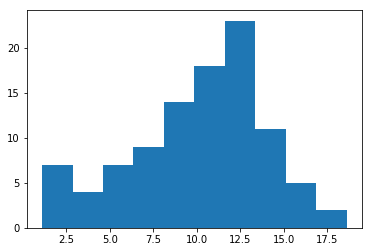

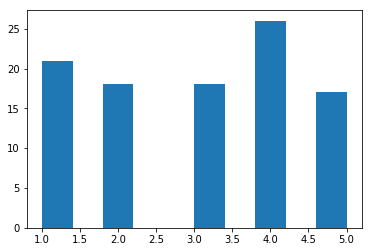

qid 0 [0, 0, 0, 0, 0, 0, 0, 0, 2.24418271031003, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.6590849398995524, 0, 0, 0, 0, 3.0839001295763007, 3.241856009006484, 0, 0, 0, 0, 0, 0, 0, 0, 8.318989710210335, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
qid 1 [0, 0, 0, 0, 0, 0, 0, 0, 2.7240706353325774, 0, 0, 0, 4.899610960465585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.871451438054501, 0, 0, 0, 0, 7.473121727315149, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.041688617458088, 0, 0, 0]
qid 2 [0, 0, 0, 8.534125291404237, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
qid 3 [0, 0, 0, 0, 0, 0, 0, 0, 6.370355201742411, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.406576060340216, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.9448508976963, 0, 0, 0, 0, 0, 0, 0, 7.411522823014753, 0, 7.357917227196943, 0, 0, 0, 0, 0, 0, 0]
qid 4 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.595279531332821, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

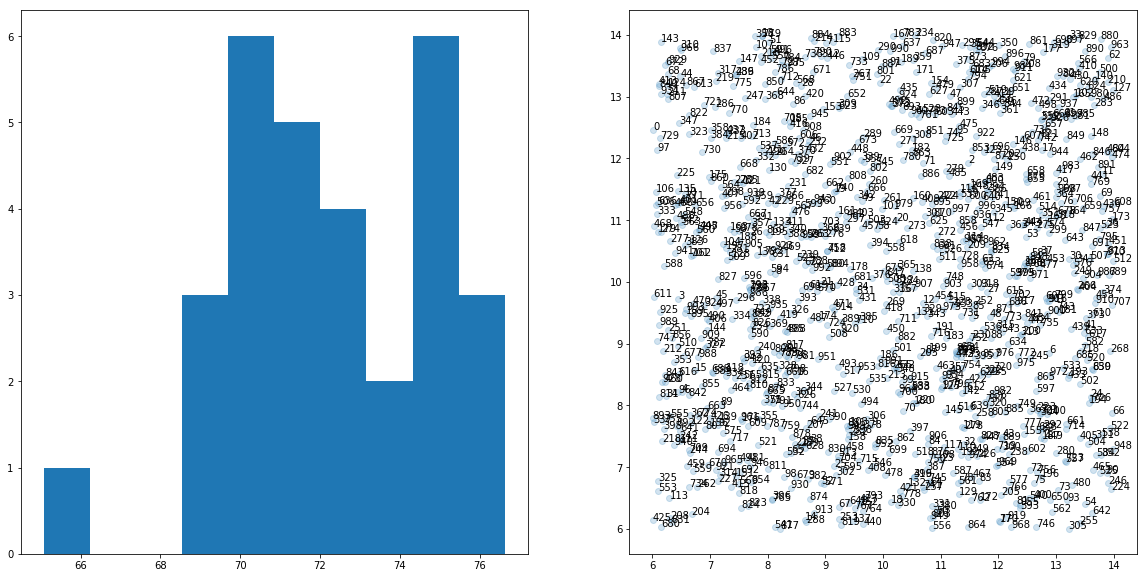

----0

>>Passed 64249/100000
----0

>>Passed 64318/100000
<__main__.BigTable object at 0x0000000579914208> <__main__.BigTable object at 0x0000000579954518> Tensor("psi_select_99:0", shape=(?, 1), dtype=int32) Tensor("q_select_99:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (100, 50)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 50)
'rows' shape, (?, 50)
kk (1000, 50)
selector shape (?, 1)
flat selector shape (?,)
call kk (1000, 50)
'rows' shape, (?, 50)
dif (?, 50)
Pr (?, 1)
[ 12.43468189   6.34120417  13.48335648   7.51203442  12.6275568
   7.17168331   9.26478004   8.12087631  12.27620506  13.51290894
  11.58639622   9.06836319  12.01782227  11.07338238   8.82209682
   6.86316299  11.88395309  12.53508472  11.25929546   7.43753099
  11.22289848   9.56766987   6.09462357  12.25151825  11.85697651
   8.54926395  13.13432693  10.43152618  13.82333279   7.57068348
  10.87493038  10.91989994   6.74715376   7.57852745  13.60918045
   6.05944586   6.30308485   9.939

[  8.51491261  12.53023911   9.54520702   6.30202675   8.14768505
   9.55357647   9.1854372   10.313591     6.48585129   8.88311386
  10.47181606  12.8303175    9.71962643   8.61173534  10.38470078
   9.39279747  11.18204212   7.20792389  12.64570522  10.9797411
  12.62316418  12.94314575   7.34225273  10.17434311   8.00940418
  13.30051041   7.75823164   7.79919577  10.65306854  12.83337593
  10.62886047   7.49387312   7.62150574   8.4849577   10.10445976
   8.79303074   9.37926388  10.10593796   9.6082592   10.98509789
  11.6415863    7.63052845  10.02059174   7.04765224   8.00610733
  11.87181282  11.51667881  13.39752483   6.00709391   7.57352734]
[ 12.07800007  12.18184948   8.78687286   6.29095459  13.60740376
  11.87527466  12.80094719   7.20970535   7.65932894  11.8329649
   7.6944828    6.72246122   7.81524134  11.22468472   7.62521887
  11.92922783  11.21792984  10.6222229    7.78379011  12.11172581
  10.42914581   8.3400135   11.0545702   13.86249542   6.14008904
  13.672179

  10.43706608   6.1450038   10.84595871   7.30377007  11.70296764]
[  7.03752661  12.82579899  11.24787235  10.01998329  12.49724865
  12.62998199  10.31337166  12.91361427  11.90498447   7.85394526
  11.3008728   10.85015297   7.28953791   9.40671349  13.49380207
   6.44458485  11.22786999  11.77693272  12.92077732  10.20471001
   9.44799042   8.75509167   6.93475628   6.25454712   8.50842953
   9.58680058  13.00760651   7.9032402    8.99559021  13.48608112
  13.42579556  12.92933369  10.96242523   9.35271263   9.70916843
  12.53940105   6.60586739   7.05495739   9.61837196   7.95946026
   6.58401871   7.78544998  12.67887592   9.67262936   9.92963505
  13.59298706   9.72931671  10.05266571   6.00026417  10.41425228]
[ 10.40615082   7.59642839   7.0984869   10.79691792  12.64580154
   7.65924358   6.36387825   7.61019707  13.51791477   9.08050442
   9.76205635  12.14162731  11.76502514  13.84299469  13.06564617
   7.86027241   7.18044043   8.87129307  12.71130276   8.04568291
  13.602

   6.04903316   7.82381868  11.83990765  13.53954124   6.3102541 ]
[ 12.56535912  12.70821667  13.20312786  12.24810791  11.73064804
  11.32604408  11.83066463  10.68483448   8.85877323  12.14899635
  10.26605701  12.69839191  11.29597187  10.9400959   13.71026421
   9.17508602  13.77403927   6.93830347   6.91000319   7.89384651
   7.04160404  11.23987007  11.22493744   9.19512749  13.39008617
   9.94087219   9.33878613   9.13022423   7.96176386   7.48516989
  10.09904099   6.91889095   6.89293146  12.50792027  13.25413704
   6.19571733   9.89172554   6.56169367  10.72531509   6.05216742
  12.25189018   6.47053862   8.6930809    9.66382027  13.6625967
  13.52103519   8.09539032  11.34706688   8.6039114    9.49578953]
[ 10.2520256    6.36874104   6.80205965  11.48922539   9.39454842
   7.71604013  10.46569824   7.08391094  13.52280331  12.47884369
  13.25096035   9.1087656   11.54337406  13.48419285  13.03593063
  12.9340086   12.36195564  11.1465044   13.27537727   9.94523811
   9.9864

  10.51141262  10.44788074  10.11716938  10.26124668  11.20828915]
[  8.07976437  12.94761848  13.91785049   8.79395294  13.67461491
  12.4298315    7.86195421  12.38303757  12.07060909   9.51413918
   8.39811897   8.96549034   8.20287323   8.94394779  13.13473988
  12.88079834   7.30291843   6.00448895  10.7900486    7.09344578
  11.56373882   8.72041512   7.45449066  12.64427948   6.23718023
   7.05342627  12.87172985  10.01970768  13.27470589  10.38389778
  11.27682495  13.70695114  13.24742603  12.74884129  11.41081619
  10.38509178  10.14923954   9.16936016  11.87269688  10.63579082
  12.60768986   8.14509583  12.50834274   8.3470726   11.25079823
   7.5006752    7.09635401   7.59984303   6.67109442   8.89088345]
[  8.85325527   9.42989731   8.2669239    6.60559559   9.26059437
  13.10567284   9.13889122  11.90273476   6.53187084  12.70759201
  12.321455     8.8772068    7.33055973  11.87417984   8.91400814
   7.48689556   9.80077267  13.34959984   8.9890995   11.78250599
   9.993

  11.22275734   6.94688654   7.07858706   8.96936417   7.81304932]
[ 13.33946609  13.42949772   6.08440161  12.77226639  12.42624474
   6.15975761   6.96634293  10.62233734  12.48539352   6.21464396
  11.73921299  12.31316662   8.80893803  13.02595043   9.11364269
   9.02214241   8.24409962   7.84102058  11.10289001   8.88688946
  13.17559147  11.83401871  12.23174191   9.30040073  10.94764996
  11.78295231   8.20005989   8.6473074    8.62230206   9.20086193
   9.07501316   9.14331913  10.49083138  11.3573103    6.85912704
  13.95165348  12.0073452   12.63696289   8.47974586  11.53422356
  13.67074585   9.56963348   6.39778233  13.29242802  11.2972784
  11.03393173   8.7681942   13.68439007   8.02270126  11.50162125]
[  9.23404121   9.40492344  10.18529701   6.10852242  12.54465389
  10.23496532  11.923769    12.61863899   8.56776333  10.91185856
  11.92572212   7.88891363   6.43830919   6.63444948  12.58781338
  11.22280884   9.30085564   9.91395378   7.82912397  12.74120426
  13.2430

   8.05994797   7.64842892   6.04323339  13.69562531  12.74587822]
[ 11.07296753   8.61055756   8.04259396  10.75941277   7.53806639
  10.62721252   9.50082207  10.96956158  13.64904785   6.92593384
  13.39435005   7.14563465  10.20965099  13.85239124   6.3983469
   6.84153605   8.89308357  10.29458332  13.62895584   9.08276081
   6.88598394  11.68335247  11.09653091   6.52609968   6.54480648
  12.74563694   7.96974659   8.47456551  13.45628643   8.43267059
  11.30992222   6.39357138  13.97179508  13.48048115   8.57349682
   7.23652172  13.93434811   9.46206951  13.44748592   9.26421452
  12.80388165   9.78694725  11.86791801   8.78389835   7.23299122
  13.70548058  11.49163628  11.74109268  10.11306     11.74566936]
[  7.20489836  12.34270859  11.63681889   6.54075098  13.93175411
   9.11415005   8.79430103  10.72293186   7.18934631  11.65502739
   7.04717922  10.06747246   6.69756794   6.58612442  11.32786179
   7.74949694   7.32767582   6.31471014  11.83369255   7.69266176
  11.2361

  10.82219124  12.30977154   7.48568153  13.32508278   9.69372845]
[ 10.06978798   7.88541651  10.11497307  12.9328022    6.00733376
  10.89682865   6.98840857   8.86946297  13.00004005   6.248209
  11.98487377   6.61386776   8.97874928  12.09142113  10.12193203
  11.74716187  12.94504547  10.94163799   6.39280558   6.17348242
   9.37892342  10.79197598  12.27989864  12.58429813   9.95327663
   8.05122375  11.02502918   8.52983189  12.53478146   7.27923441
  12.74183083  12.52874756   8.75363445  10.4172163    8.86421776
  13.92519283   9.79918861   9.65420818   7.26390886  10.00909424
   7.42779684  11.10363483  11.67011547   6.06251955  11.57580853
   9.5577116   12.47736645  11.06704044   6.30065918  10.05968666]
[  6.41479158   7.61507416  11.60265732  10.93220997   8.13263893
   8.53664494   8.75730896   7.61096573  11.5008812   13.18633938
   8.39305115  13.24948692   9.91208076   9.33048439   9.44259071
  13.2484045   12.0836277    7.94421339  10.04075813  12.3729744    6.935956

[ 2.9303968   8.19982052  8.16086292  5.54419327  2.01602745  4.89461565
  5.41746092  7.82348299  9.39535904  1.56866014  3.01362062  8.58945751
  1.92768049  4.79854679  1.85024095  4.30960655  8.88562679  5.87711811
  5.92258358  6.57828045  8.49379921  9.60942936  6.07818604  3.09217477
  9.00792217  4.0823884   9.56946659  4.71425676  1.36728168  7.8282671
  2.67406178  2.71469903  9.97647762  4.46179438  5.05401945  4.6670022
  4.59765482  5.49735785  1.60291684  4.10062647  5.52431154  6.1178174
  6.3664813   4.96869802  4.53151703  4.95206022  5.07517529  5.18278933
  7.26946926  5.80685091]
[ 3.71291709  8.51869202  3.28802347  7.25580645  5.3440485   7.85402393
  2.78523254  8.83970928  1.73216927  3.88262248  1.73183179  4.46072912
  1.50556254  5.17688608  8.79721355  7.2701726   7.18075037  8.08254528
  9.90555286  6.71264791  5.50167179  1.88061655  6.2894578   4.00601625
  6.572855    8.34236145  5.4430213   1.24707496  2.2968154   5.13941765
  1.60813165  9.33987427  5.

[11 18  6 ..., 38 41 44]
[664 451 408 ..., 569 494 597]
[1 0 1 ..., 1 0 1]
i = 0
6.90388208313 0.639438316917 0.3592
[ 10109.0234375   10052.95996094  10096.00683594   9967.17285156
  10172.26953125  10084.17578125  10079.69238281  10011.66699219
   9979.00878906  10148.9765625    9979.81933594   9897.36621094
  10073.59277344   9925.71582031  10003.45410156  10047.85449219
   9947.70605469   9991.40625     10159.6953125   10111.62011719
  10050.859375    10037.75878906  10146.33789062  10113.35253906
  10192.85742188  10123.51855469  10222.55859375   9934.4140625
  10182.18359375  10028.52734375  10020.45898438   9983.984375
  10114.69433594   9975.58496094  10277.47167969  10029.67285156
  10011.4921875   10072.63769531  10114.41308594  10136.6171875
  10106.17871094  10021.86425781  10100.15917969  10090.56738281
   9990.56445312  10109.48242188  10160.703125     9992.75        10065.63183594
  10066.41503906]
av RMSE= 6.90388208313
patience reset to 10
i = 10
2.06805881195 0.548450

i = 100
0.570717048836 0.194789941669 0.6904
[ 11356.81445312  11560.22949219  11852.38378906  11450.49316406
  11809.41894531  11642.62792969  11488.30957031  11690.75390625
  11818.76074219  11369.71972656  11582.11425781  11134.33300781
  11340.30273438  11441.94042969  11296.63183594  11427.56835938
  11666.96777344  11401.24902344  11459.63183594  11240.41503906
  11724.08984375  11511.7578125   11781.02148438  11460.02832031
  11770.28027344  11624.95996094  11933.74804688  11623.19433594
  11608.65429688  11247.64257812  11295.39550781  11520.24902344
  11426.51953125  11783.11328125  11833.49902344  11431.98730469
  11265.13867188  11545.375       11583.05664062  11649.74511719
  11738.1796875   11422.81054688  11497.38183594  11583.88867188
  11423.99023438  11790.02441406  11489.125       11395.78710938
  11710.0859375   11618.0390625 ]
av RMSE= 0.570717048836
patience now 7
i = 110
0.570551628208 0.194948476291 0.6898
[ 11345.58203125  11556.859375    11861.95410156  11454.1

2383

In [537]:
from IPython.display import clear_output
serieses = []
min_errs = []
n_qs = 100
n_students = 1000
opt = Adam(lr=.1)# (lr=.75)

# 1 (1836, (4279, 4082, 825, 814), 3, 14, 2, 13)
# 2 (2320, (3840, 3965, 1082, 1113), 10, 20, 9, 16)
# 3 (2398, (4258, 3801, 968, 973), 7, 18, 3, 14)
# 5 (2752, (3624, 3697, 1354, 1325), 8, 16, 3, 12)
# 10 (3640, (3269, 3180, 1769, 1782), 8, 15, 2, 10)
# 25 (4990, (3100, 2505, 2154, 2241), 7, 17, 4, 7)
#100 (3544, (3228, 3330, 1705, 1737), 21, 44, 1, 23)

# mina=8
# maxa=16
# minb=3
# maxb=12
# n_traits=5
# nn_dimensions=[5]

# mina, maxa, minb, max_b = (3, 14, 2, 13)
# n_traits=1
# nn_dimensions=[1]

# mina, maxa, minb, max_b = (10, 20, 9, 16)
# mina, maxa, minb, max_b = (2, 12, 1, 8)
# n_traits=2
# nn_dimensions=[2]

mina, maxa, minb, maxb = ( 6, 14, 1, 10)
# n_traits= 95
min_active_traits = 1
max_active_traits = 5

nn_dimensions=[50]

histoires = []

qs=None
ss=None
for ix,nnw in enumerate(nn_dimensions):
    n_traits = nnw
    if not qs:
        qs= create_qs(n_qs, minb,maxb, n_traits, min_active_traits, max_active_traits, nnw)
        ss= create_students(n_students, mina,maxa, n_traits, nnw)
        attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
        v, _, _, _ = generate_attempts(qs,ss)
    
    q_table = BigTable((n_qs, nnw),min_w=0, max_w=maxb)
    s_table = BigTable((n_students, nnw), min_w=mina, max_w=maxa)

    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, None, None, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
#     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb,maxb, mina,maxa)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb,maxb, mina,maxa)# 1, 2, 10, 20)

#     init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, (minb+maxb)/4, (minb+maxb)/1.8, (mina+maxa)/4, (mina+maxa)/1.8)
 
    h = calibrate(qs,ss, qs_model, q_model, s_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, None, None, n_iter=100000, record_param_fit=True)
    histoires.append(h)
    
    #qs_model.load_weights("qs_best_weights_summative.hdf5")
    
gc.collect()

In [527]:
x = []

for _ in range(1):
    xa, _, _, _ = generate_attempts(qs,ss)
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

----0

>>Passed 64298/100000
model acc: 0.77779
53118 11041
11180 24661
perplexity is 1.4164402513951606
50678 : 53118 24661 11041 11180


In [523]:
sws = s_table.get_weights()[0]

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(sws[psi_id], pred_wgtz[q_id])
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

model acc: 0.8153
52710 9125
9345 28820
perplexity is 1.3700931478350034
42360 : 52710 28820 9125 9345


(100, 100) (100, 100)


c:\venvs\isaac64\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


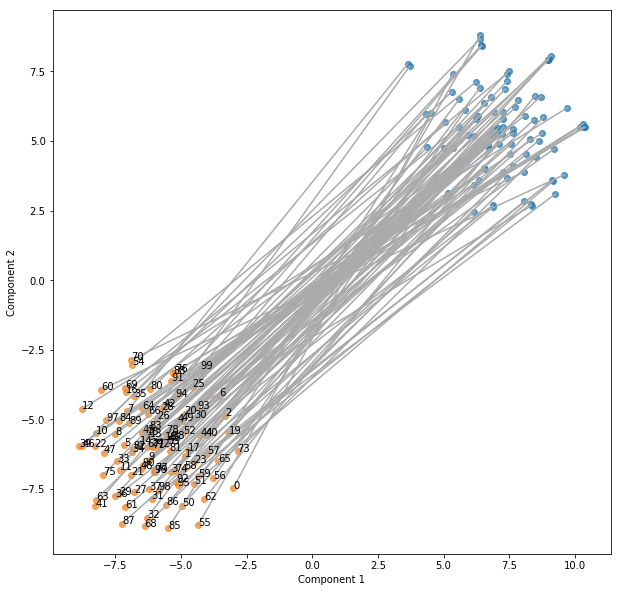

In [536]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)
rot = array([[-1,0],[0,-1]])

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# for nx in range(n):
#     itemz_2[n+nx] = rot @ itemz_2[n+nx]


# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()